### Задача состоит в следующем: по известным данным определить тип поломки машины (target_class). Используемая метрика - Recall
### Даны четыре датасета: с информацией о машинах, информацией о водителях, информацией о ремонтах, информацией о поездках.

In [1]:
import pandas as pd
import numpy as np

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score

## Описание машин с информацией о поломках

In [2]:
car_train = pd.read_csv(r"C:\Users\savus\ML\Задача\car_train.csv")
display(car_train)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,30.34,engine_fuel
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,30.45,engine_fuel
...,...,...,...,...,...,...,...,...,...,...
2332,j21246192N,Smart ForFour,economy,petrol,4.38,2017,121239,2018,25.48,wheel_shake
2333,h-1554287F,Audi A4,premium,petrol,4.30,2016,107793,2020,69.26,engine_check
2334,A15262612g,Kia Rio,economy,petrol,3.88,2015,80234,2019,46.03,gear_stick
2335,W-2514493U,Renault Sandero,standart,petrol,4.50,2014,60048,2020,77.19,another_bug


- car_id — идентификатор машины;
- model / car_type / fuel_type — марка, класс и тип топлива машины;
- car_rating / riders — общий рейтинг  и общее число поездок к концу 2021-го года;
- year_to_start / year_to_work — год выпуска машины и начала работы в автопарке;
- target_reg — количество дней до поломки;
- target_class — класс поломки (всего 9 видов).

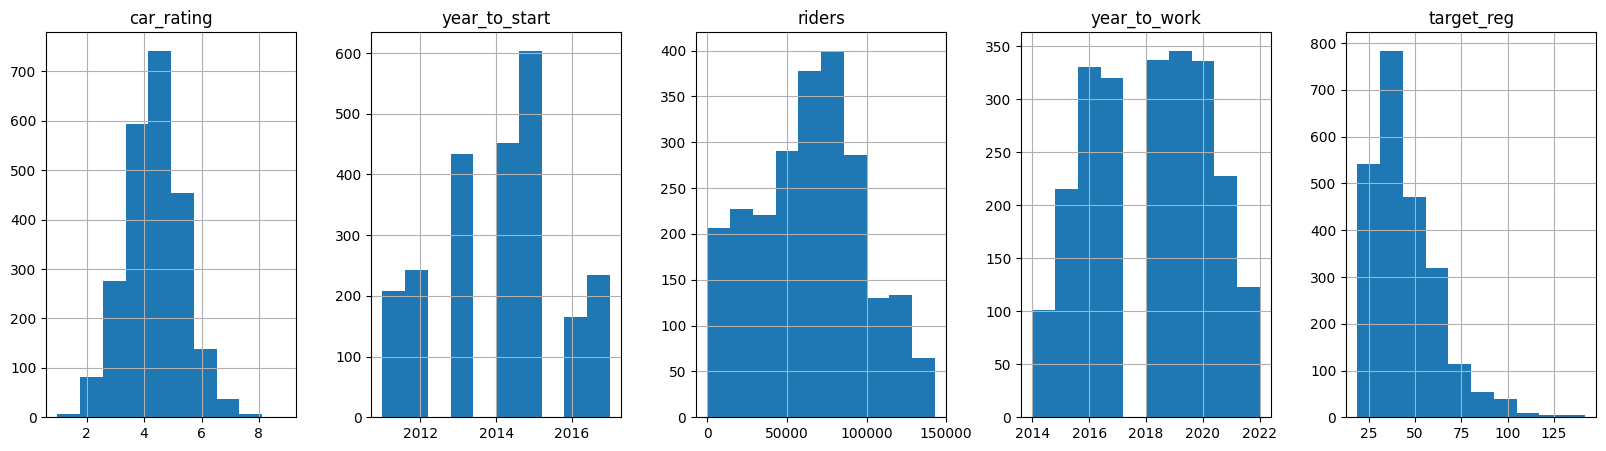

In [3]:
car_train.hist(figsize=(20, 5), layout = (-1, 5));

In [4]:
car_train.describe()

,car_rating,year_to_start,riders,year_to_work,target_reg
count,2337.000000,2337.000000,2337.000000,2337.000000,2337.000000
mean,4.354292,2014.040650,63711.443731,2018.069748,44.946735
std,0.996954,1.685852,33755.012096,2.159484,17.579568
min,0.980000,2011.000000,23.000000,2014.000000,18.920000
25%,3.740000,2013.000000,41053.000000,2016.000000,31.670000
50%,4.360000,2014.000000,64415.000000,2018.000000,40.170000
75%,5.000000,2015.000000,86515.000000,2020.000000,54.790000
max,8.900000,2017.000000,142862.000000,2022.000000,141.630000


## Информация о водителях

In [5]:
driver_info = pd.read_csv(r"C:\Users\savus\ML\Задача\driver_info.csv")
display(driver_info)

,age,user_rating,user_rides,user_time_accident,user_id,sex,first_ride_date
0,27,9.0,865,19.0,l17437965W,1,2019-4-2
1,46,7.9,2116,11.0,Z12362316j,0,2021-11-19
2,59,7.8,947,4.0,g11098715c,0,2021-1-15
3,37,7.0,18,4.0,U12618125q,0,2019-11-20
4,39,8.2,428,7.0,A14375829B,0,2019-7-23
...,...,...,...,...,...,...,...
15148,19,7.9,52,12.0,R13807707w,1,2019-12-1
15149,40,7.6,1142,3.0,F86199947G,0,2019-1-18
15150,27,7.9,1280,3.0,O10119419p,1,2018-9-16
15151,30,7.9,31,5.0,B35483077Y,0,2019-11-23


- user_id / age /sex— идентификатор, возраст и пол водителя, соответственно
- user_rating — общий рейтинг пользователя за все поездки к концу 2021-го года
- user_rides — общее количество поездок к концу 2021-го года
- user_time_accident— число инцидентов (это могли быть аварии/штрафы/эвакуация машины)
- first_ride_date — дата первой поездки

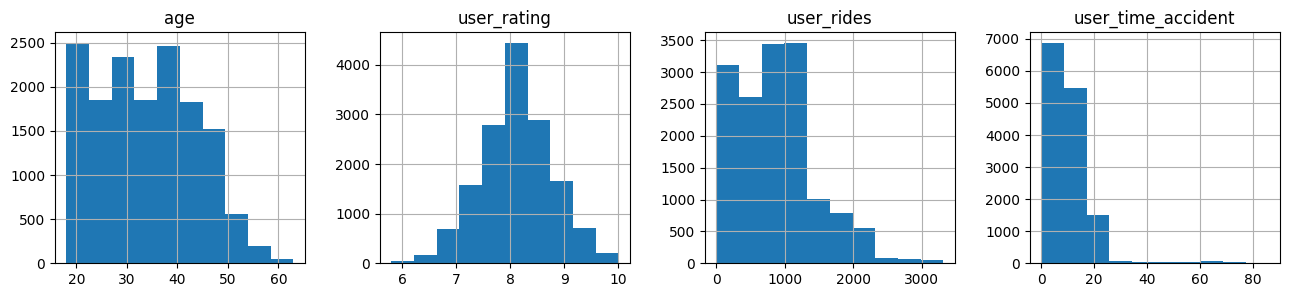

In [6]:
driver_info[['age', 'user_rating', 'user_rides', 'user_time_accident']].hist(figsize=(20, 3), layout = (-1, 5));

In [7]:
driver_info.describe()

,age,user_rating,user_rides,user_time_accident,sex
count,15153.000000,15153.000000,15153.000000,14182.000000,15153.000000
mean,33.581073,8.109345,871.015442,10.129601,0.499967
std,9.919271,0.668246,573.512378,8.867482,0.500016
min,18.000000,5.800000,0.000000,0.000000,0.000000
25%,25.000000,7.700000,421.000000,4.000000,0.000000
50%,33.000000,8.100000,876.000000,9.000000,0.000000
75%,41.000000,8.600000,1145.000000,14.000000,1.000000
max,63.000000,10.000000,3316.000000,86.000000,1.000000


## Информация про ремонт машин

In [8]:
fix_info = pd.read_csv(r"C:\Users\savus\ML\Задача\fix_info.csv")
display(fix_info)

,car_id,worker_id,fix_date,work_type,destroy_degree,work_duration
0,P17494612l,RJ,2020-6-20 2:14,reparking,8.0,49
1,N-1530212S,LM,2020-2-9 20:25,repair,10.0,48
2,B-1154399t,ND,2019-8-24 7:1,reparking,1.0,27
3,y13744087j,PG,2019-8-10 9:29,reparking,1.0,28
4,F12725233R,YC,2020-11-12 5:22,refuel_check,8.0,47
...,...,...,...,...,...,...
145995,j92079780S,NG,2019-1-21 14:34,reparking,1.0,36
145996,N89944460U,WM,2019-4-30 11:33,repair,2.6,13
145997,f63189062N,NY,2019-3-7 20:49,repair,5.0,14
145998,j-1712772o,IP,2018-2-18 19:10,repair,5.0,13


- worker_id / car_id — идентификатор работника и машины
- work_type / work_duration — тип и длительность (в часах) проводимой работы
- destroy_degree — степень износа/повреждённости машины в случае поломки
- fix_date — время начала ремонта (снятия машины с линии)

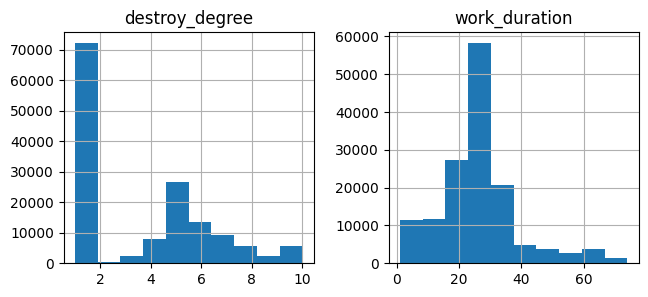

In [9]:
fix_info.hist(figsize=(20, 3), layout = (-1, 5));

## Информация про поездки

In [10]:
rides_info = pd.read_csv(r"C:\Users\savus\ML\Задача\rides_info.csv")
display(rides_info)

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
0,o52317055h,A-1049127W,b1v,2020-01-01,4.95,21,268,36,113.548538,0,514.246920,0,1.115260,2.909
1,H41298704y,A-1049127W,T1U,2020-01-01,6.91,8,59,36,93.000000,1,197.520662,0,1.650465,4.133
2,v88009926E,A-1049127W,g1p,2020-01-02,6.01,20,315,61,81.959675,0,1276.328206,0,2.599112,2.461
3,t14229455i,A-1049127W,S1c,2020-01-02,0.26,19,205,32,128.000000,0,535.680831,0,3.216255,0.909
4,W17067612E,A-1049127W,X1b,2020-01-03,1.21,56,554,38,90.000000,1,1729.143367,0,2.716550,-1.822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739495,I15732675M,z91796444U,m1z,2020-03-30,7.42,164,2290,49,54.586302,0,2274.772387,0,6.137593,-39.752
739496,r51579957X,z91796444U,t1P,2020-03-30,4.19,26,412,46,73.000000,0,515.580231,0,6.703367,-38.480
739497,l15212727I,z91796444U,z1A,2020-03-31,3.40,23,178,37,71.000000,1,444.846677,0,6.255344,-45.080
739498,Z78949958q,z91796444U,w1R,2020-04-01,9.02,5,75,48,87.000000,1,179.464361,0,7.759949,-60.193


- user_id / car_id / ride_id  — идентификаторы водителя, машины и поездки, соответственно
- ride_date / rating — дата поездки и рейтинг, поставленный водителем
- ride_duration / distance / ride_cost —  длительность (время),  пройденное расстояние, стоимость поездки
- speed_avg / speed_max — средняя и максимальная скорости поездки
- stop_times / refueling — количество остановок (паузы) и флаг, была ли дозаправка
- user_ride_quality — оценка манеры вождения в машины водителя, определенная скоринговой ML-системой сервиса
- deviation_normal — общий показатель датчиков о состоянии машины, относительно эталонных показателей (нормы)

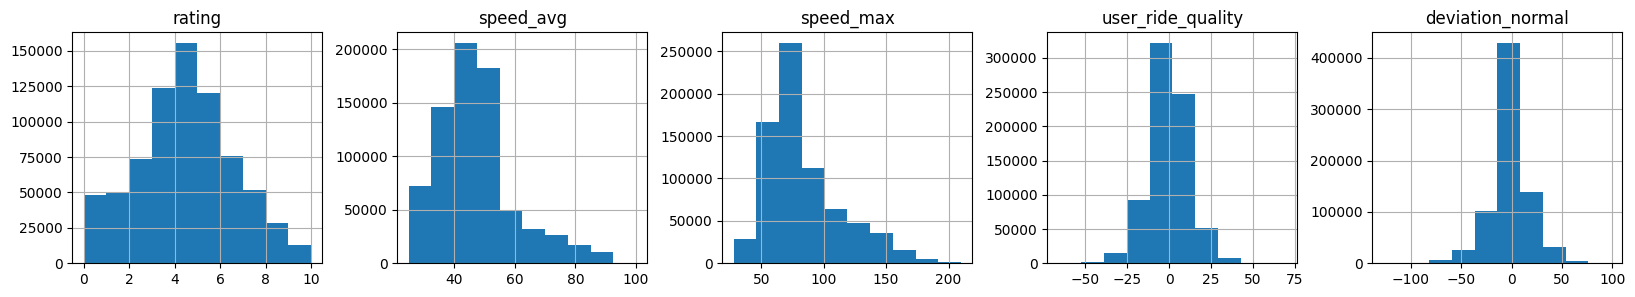

In [11]:
rides_info[['rating', 'speed_avg', 'speed_max', 'user_ride_quality', 'deviation_normal']].hist(figsize=(20, 3), layout = (-1, 5));

### Выбрасываем ненужные фичи, определяем категариальные и континуальные фичи, а так же таргеты

In [12]:
drop_features = ['car_id']
targets = ['target_class', 'target_reg']
categorical_features = ['model', 'car_type', 'fuel_type']

filtered_features = [i for i in car_train.columns if (i not in targets and i not in drop_features)]
num_features = [i for i in filtered_features if i not in categorical_features]

### Базовая модель

In [13]:
X = car_train[filtered_features].drop(targets, axis=1, errors='ignore')
y = car_train['target_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = CatBoostClassifier(cat_features=categorical_features)


clf.fit(X_train, y_train, 
          eval_set=(X_test, y_test),
          verbose=200, 
          early_stopping_rounds=5, 
          plot=False)

y_pred = clf.predict(X_test)
print(f'\n Recall: {recall_score(y_test, y_pred, average="macro")}')

Learning rate set to 0.109335
0:	learn: 2.1911361	test: 2.1951349	best: 2.1951349 (0)	total: 167ms	remaining: 2m 47s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 2.19089351
bestIteration = 6

Shrink model to first 7 iterations.

 Recall: 0.09260476221139796


### Крайне низкий скор, очевидно, надо добавить немного фичей. Добавим информацию о поездках

In [14]:
f = lambda x: x.nunique()
rides_gr = rides_info.groupby('car_id', as_index=False).agg(mean_rating = ('rating', 'mean'),
                                                   distance_sum = ('distance', 'sum'),
                                                   rating_min = ('rating', 'min'),
                                                   speed_max = ('speed_max', 'max'),
                                                   user_ride_quality_median = ('user_ride_quality', 'median'), 
                                                   deviation_normal_mean = ('deviation_normal', 'mean'),
                                                   user_uniq = ('user_id', f))

display(rides_gr)

,car_id,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_mean,user_uniq
0,A-1049127W,4.255172,1.125753e+07,0.10,179.729652,-0.288229,-6.136672,172
1,A-1079539w,4.088046,1.912765e+07,0.10,184.505566,2.508746,47.443270,173
2,A-1162143G,4.662299,2.995194e+06,0.10,180.000000,0.639653,10.556425,172
3,A-1228282M,4.225172,1.793685e+07,0.10,182.446070,-15.663698,9.810747,174
4,A-1339912r,4.690115,1.202552e+07,0.10,152.000000,-9.893439,22.965937,172
...,...,...,...,...,...,...,...,...
4245,z73688663a,4.808448,1.113943e+07,0.10,165.000000,-1.476784,-13.846075,168
4246,z73740510r,4.699655,7.215961e+06,0.28,117.397405,15.144468,7.026477,171
4247,z86911952C,4.430977,2.135104e+07,0.00,173.428116,-5.366843,-25.382126,172
4248,z91353693Z,5.326092,1.614384e+07,0.10,106.089167,6.886681,-8.031167,173


In [15]:
def add_featues(df):
    
    if 'mean_rating' not in df.columns:
        return df.merge(rides_gr, on = 'car_id', how = 'left')    
    return df

car_test = pd.read_csv(r"C:\Users\savus\ML\Задача\car_test.csv")    

car_train = add_featues(car_train)
car_test = add_featues(car_test)
display(car_train)
car_train.nunique()

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_mean,user_uniq
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,4.737759,1.214131e+07,0.10,180.855726,0.023174,-0.120391,170
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug,4.480517,1.803909e+07,0.00,187.862734,12.306011,6.050011,174
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick,4.768391,1.588366e+07,0.10,102.382857,2.513319,-2.223954,173
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,30.34,engine_fuel,3.880920,1.651883e+07,0.10,172.793237,-5.029476,14.771948,170
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,30.45,engine_fuel,4.181149,1.398317e+07,0.10,203.462289,-14.260456,12.455678,171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332,j21246192N,Smart ForFour,economy,petrol,4.38,2017,121239,2018,25.48,wheel_shake,4.608908,1.739222e+07,0.10,141.502350,-6.624534,2.914989,171
2333,h-1554287F,Audi A4,premium,petrol,4.30,2016,107793,2020,69.26,engine_check,4.683793,1.174052e+07,0.10,155.000000,-8.582467,-18.805856,169
2334,A15262612g,Kia Rio,economy,petrol,3.88,2015,80234,2019,46.03,gear_stick,4.655345,1.202022e+07,0.10,104.180940,-0.778524,-7.651776,172
2335,W-2514493U,Renault Sandero,standart,petrol,4.50,2014,60048,2020,77.19,another_bug,4.638333,1.788307e+07,0.10,200.000000,2.464975,0.468718,171


car_id                      2337
model                         26
car_type                       4
fuel_type                      2
car_rating                   269
year_to_start                  7
riders                      2306
year_to_work                   9
target_reg                  1891
target_class                   9
mean_rating                 2223
distance_sum                2337
rating_min                    91
speed_max                   1938
user_ride_quality_median    2337
deviation_normal_mean       2334
user_uniq                     30
dtype: int64

In [16]:
car_train.to_pickle('task_intro')
car_test.to_pickle('task_intro_test')

### Обновляем фичи

In [17]:
filtered_features = [i for i in car_train.columns if (i not in targets and i not in drop_features)]
num_features = [i for i in filtered_features if i not in categorical_features]

### Строим другую базовую модель

In [18]:
X = car_train[filtered_features].drop(targets, axis=1, errors='ignore')
y = car_train['target_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = CatBoostClassifier(cat_features=categorical_features)


clf.fit(X_train, y_train, verbose=0)

# инференс модели
y_pred = clf.predict(X_test)
print(f'\n Recall: {recall_score(y_test, y_pred, average="macro")}')


 Recall: 0.8017093884414951


### Будем рассматривать Recall = 0.8017 как базлайн